In [32]:
import sys
import os

import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score
sys.path.append(os.path.dirname(os.getcwd()))

from dbn_nslkdd.dbn.models import UnsupervisedDBN

from pathlib import Path

In [96]:
DATA_PATH = Path('..') / 'data'
RAW_DATA_PATH = DATA_PATH / 'raw'
PROCESSED_DATA_PATH = DATA_PATH / 'processed_v3'

MODELS_PATH = Path('..') / 'models'

LOAD_MODEL = False

VAL_SIZE = 5000
TEST_VAL_SIZE = 17543
TRAIN_SIZE = 125972

# Load Data

In [97]:
shap_values_train = np.fromfile(PROCESSED_DATA_PATH / 'shap_values_train_from_xgboost.npy')
shap_values_train = shap_values_train.reshape(TRAIN_SIZE, 41)

shap_values_test = np.fromfile(PROCESSED_DATA_PATH / 'shap_values_test_from_xgboost.npy')
shap_values_test = shap_values_test.reshape(TEST_VAL_SIZE, 41)

shap_values_val = np.fromfile(PROCESSED_DATA_PATH / 'shap_values_val_from_xgboost.npy')
shap_values_val = shap_values_val.reshape(VAL_SIZE, 41)

y_test   = pd.read_csv(PROCESSED_DATA_PATH / 'y_test.csv')
y_val   = pd.read_csv(PROCESSED_DATA_PATH / 'y_val.csv')



# Scale Data

In [98]:
scaler = MinMaxScaler()
shap_values_train_scaled = scaler.fit(shap_values_train).transform(shap_values_train)
shap_values_test_scaled = scaler.fit(shap_values_test).transform(shap_values_test)
shap_values_val_scaled = scaler.fit(shap_values_val).transform(shap_values_val)

# Run DBN

In [99]:
N_EPOCHS_RBM = 50
dbn = UnsupervisedDBN(hidden_layers_structure=[41, 41],
                      learning_rate_rbm=0.06,
                      n_epochs_rbm=N_EPOCHS_RBM,
                      activation_function='sigmoid')

In [102]:
if LOAD_MODEL:
    dbn = UnsupervisedDBN.load(MODELS_PATH / 'dbn_unsupervised_with_shap_v1.model')
else:
    dbn.fit(shap_values_test_scaled)

dbn.save(MODELS_PATH / 'dbn_unsupervised_with_shap_v1.model')

[START] Pre-training step:
>> Epoch 1 finished 	RBM Reconstruction error 0.402105
>> Epoch 2 finished 	RBM Reconstruction error 0.356276
>> Epoch 3 finished 	RBM Reconstruction error 0.327203
>> Epoch 4 finished 	RBM Reconstruction error 0.314280
>> Epoch 5 finished 	RBM Reconstruction error 0.299740
>> Epoch 6 finished 	RBM Reconstruction error 0.289141
>> Epoch 7 finished 	RBM Reconstruction error 0.274104
>> Epoch 8 finished 	RBM Reconstruction error 0.279415
>> Epoch 9 finished 	RBM Reconstruction error 0.268081
>> Epoch 10 finished 	RBM Reconstruction error 0.264025
>> Epoch 11 finished 	RBM Reconstruction error 0.265969
>> Epoch 12 finished 	RBM Reconstruction error 0.261182
>> Epoch 13 finished 	RBM Reconstruction error 0.257156
>> Epoch 14 finished 	RBM Reconstruction error 0.257214
>> Epoch 15 finished 	RBM Reconstruction error 0.253634
>> Epoch 16 finished 	RBM Reconstruction error 0.253720
>> Epoch 17 finished 	RBM Reconstruction error 0.250137
>> Epoch 18 finished 	RBM Reco

In [103]:
K = 10
reconstructed_shap_values = dbn.reconstruct_k(shap_values_test_scaled, K)

In [105]:
thresh_hold = 0.06

ARE = abs(reconstructed_shap_values - shap_values_test_scaled)

are_df = pd.DataFrame(ARE)

are_avg_list = pd.DataFrame(are_df.mean(axis=1)).values.tolist()

are_avg = [1 if item[0] > thresh_hold else 0 for item in are_avg_list]
are_avg_df = pd.DataFrame(are_avg)

are_avg_df.to_csv(PROCESSED_DATA_PATH / 'dbn_model_test_results.csv')
np.save(PROCESSED_DATA_PATH / 'dbn_model_test_results.npy', are_avg, allow_pickle=True)

print(f'accuracy_score: {accuracy_score(y_test, are_avg_df)}')
print(f'precision_score: {precision_score(y_test, are_avg_df)}')
print(f'recall_score {recall_score(y_test, are_avg_df)}')

accuracy_score: 0.8641053411617169
precision_score: 0.94217568353694
recall_score 0.8110165247871808


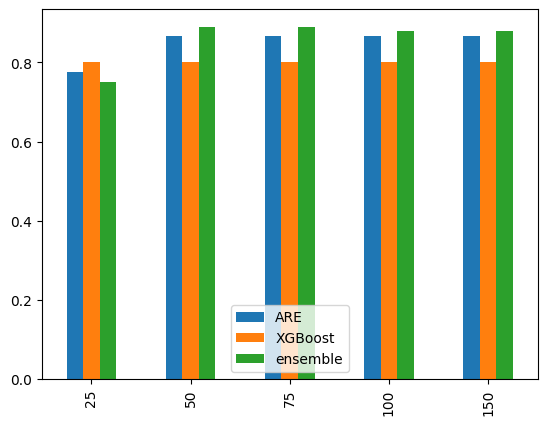

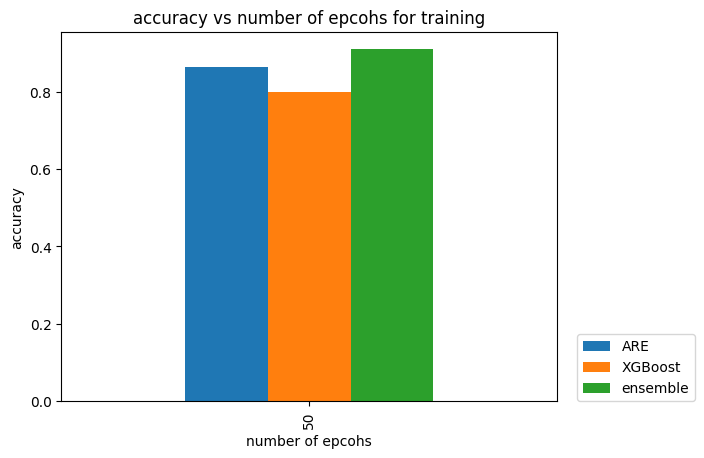

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


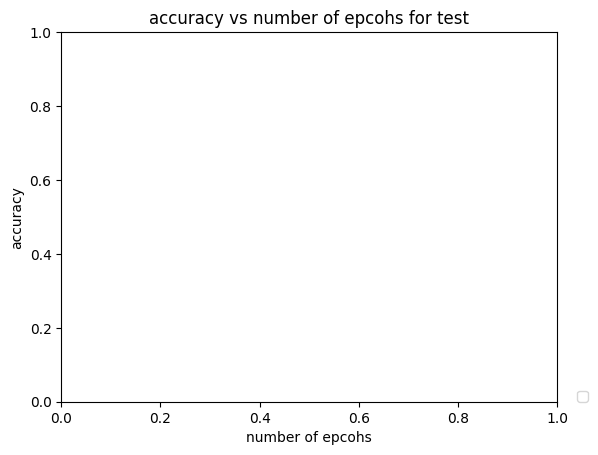

In [107]:
import matplotlib.pyplot as plt

def valuelabel(weight,students):
    for i in range(len(weight)):
        plt.text(i,students[i],students[i], ha = 'center',
                 bbox = dict(facecolor = 'cyan', alpha =0.8))
        
results_training = {'25':  {'ARE': 0.776, 'XGBoost': 0.80, 'ensemble': 0.75},
                   '50':  {'ARE': 0.866, 'XGBoost': 0.80, 'ensemble': 0.89},
                   '75':  {'ARE': 0.867, 'XGBoost': 0.80, 'ensemble': 0.89},
                   '100': {'ARE': 0.868, 'XGBoost': 0.80, 'ensemble': 0.88},
                   '150': {'ARE': 0.868, 'XGBoost': 0.80, 'ensemble': 0.88}}

results_test = {'50':  {'ARE': 0.864, 'XGBoost': 0.80, 'ensemble': 0.91}}

results_train_df = pd.DataFrame(results_training)
results_train_df.transpose().plot.bar()

results_test_df = pd.DataFrame(results_test)
results_test_df.transpose().plot.bar()

plt.legend(loc=(1.04, 0))
plt.title('accuracy vs number of epcohs for training')
plt.xlabel('number of epcohs')
plt.ylabel('accuracy')


plt.show()

plt.legend(loc=(1.04, 0))
plt.title('accuracy vs number of epcohs for test')
plt.xlabel('number of epcohs')
plt.ylabel('accuracy')


plt.show()



In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn import preprocessing
pca = PCA(n_components=41)

scaler = preprocessing.StandardScaler()

X_train = pd.DataFrame(scaler.fit(X_train).transform(X_train))

X_train_PCA = pca.fit_transform(X_train)
X_train_PCA_df = pd.DataFrame(X_train_PCA)

colors = {0:'blue', 1:'red'}
fig, ax = plt.subplots()
ax.scatter(X_train_PCA_df[0], X_train_PCA_df[1], c=y_train.map(colors))

exp_var_pca = pca.explained_variance_ratio_

cum_sum_eigenvalues = np.cumsum(exp_var_pca)

plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()